<a href="https://colab.research.google.com/github/EmanuelAlogna/MRI-generation/blob/master/src/MRI_generation_with_pix2pix(P2P_t2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython import display
import time
import math

print(tf.__version__)

from google.colab import drive
drive.mount('/content/drive')

2.0.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def get_feature_description(modalities):                                                   
                                                                                           
    feature_description =lambda mod : {                                                    
                            mod+'_mri': tf.io.FixedLenFeature([], tf.string),              
                            mod+'_path': tf.io.FixedLenFeature([], tf.string),             
                                                                                           
                            mod+'_mri_min': tf.io.FixedLenFeature([], tf.float32),         
                            mod+'_mri_min_src': tf.io.FixedLenFeature([], tf.float32),     
                            mod+'_mri_max': tf.io.FixedLenFeature([], tf.float32),         
                            mod+'_mri_max_src': tf.io.FixedLenFeature([], tf.float32),     
                                                                                           
                            mod+'_mri_lperc': tf.io.FixedLenFeature([], tf.float32),       
                            mod+'_mri_hperc': tf.io.FixedLenFeature([], tf.float32),       
                            mod+'_mri_hperc_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_mri_lperc_src': tf.io.FixedLenFeature([], tf.float32),   
                                                                                           
                            mod+'_x_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_y_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_z_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_z_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                            mod+'_x_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                            mod+'_y_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                                                                                           
                            mod+'_x_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                            mod+'_y_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                            mod+'_z_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                                                                                           
                            mod+'_z_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_x_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_y_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                                                                                           
                            mod+'_patient': tf.io.FixedLenFeature([], tf.string),          
                            mod+'_sample_number': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_patient_grade': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_location': tf.io.FixedLenFeature([], tf.string),         
                            mod+'_dataset_version': tf.io.FixedLenFeature([], tf.string),  
                            mod+'_dataset_name': tf.io.FixedLenFeature([], tf.string),     
                            mod+'_mri_type': tf.io.FixedLenFeature([], tf.string),         
                            mod+'_dataset_split': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_patient_mri_seq': tf.io.FixedLenFeature([], tf.string),  
                          }                                                                
    features = {}                                                                          
    for mod in modalities:
        features.update(feature_description(mod))
    return features

In [0]:
#BUFFER_SIZE = 400
BATCH_SIZE = 32

In [0]:
use_gzip_compression = True

def load_dataset(name, mri_type, center_crop=None, random_crop=None, filter=None, batch_size=BATCH_SIZE, cache=True, 
                 prefetch_buffer=1, shuffle_buffer=128, interleave=1, cast_to=tf.float32, clip_labels_to=0.0, 
                 take_only=None, shuffle=True, infinite=False, n_threads=os.cpu_count()):
    def parse_sample(sample_proto):
        parsed = tf.io.parse_single_example(sample_proto, get_feature_description(["OT"]+mri_type))
        # Decoding image arrays
        
        slice_shape = [parsed['OT_x_dimension'.format(mri_type[0])], parsed['OT_y_dimension'], 1]
        # Decoding the ground truth
        parsed['seg'] = tf.cast(tf.reshape(tf.io.decode_raw(parsed['OT_mri'], tf.float32), shape=slice_shape), dtype=cast_to)
        # Decode each channel and stack in a 3d volume
        stacked_mri = list()
        for mod in mri_type:
            stacked_mri.append(tf.cast(tf.reshape(tf.io.decode_raw(parsed['{}_mri'.format(mod)], tf.float32), shape=slice_shape), dtype=cast_to))
        parsed['mri'] = tf.concat(stacked_mri, axis=-1)
        # Clipping the labels if requested
        parsed['seg'] = tf.clip_by_value(parsed['seg'], 0.0, clip_labels_to) if clip_labels_to else parsed['seg']
        
        # Cropping
        if random_crop or center_crop:
            # Stacking the mri and the label to align the crop shape
            mri_seg = tf.concat([parsed['mri'], parsed['seg']], axis=-1)
            if random_crop:
                random_crop[-1] = mri_seg.shape[-1] 
                cropped = tf.image.random_crop(mri_seg, size=random_crop)
            else:
                cropped = tf.image.resize_with_crop_or_pad(mri_seg,center_crop[0],center_crop[1])
            # Splitting back
            parsed['mri'] = cropped[:,:,:len(mri_type)]
            parsed['seg'] = cropped[:,:,len(mri_type):]
        
        return parsed
    
    path = './drive/My Drive/MRI-generation/{}.tfrecords'.format(name)
    dataset = tf.data.TFRecordDataset(path, compression_type='GZIP' if use_gzip_compression else "")
    dataset = dataset.filter(filter) if filter is not None else dataset
    dataset = dataset.take(take_only) if take_only is not None else dataset

    # You should generally cache after loading and preprocessing the data, 
    # but before shuffling, repeating, batching and prefetching”
    dataset = dataset.cache() if cache else dataset
    if shuffle and infinite:
        dataset = dataset.apply(tf.data.experimental.shuffle_and_repeat(shuffle_buffer))
    else:
        dataset = dataset.shuffle(shuffle_buffer, reshuffle_each_iteration=True) if shuffle else dataset
        dataset = dataset.repeat() if infinite else dataset
    dataset = dataset.map(parse_sample, num_parallel_calls=None)
    dataset = dataset.batch(batch_size) if batch_size > 0 else dataset
    
    

    if interleave > 1:
        dataset = dataset.interleave(lambda x: tf.data.Dataset.from_tensors(x).repeat(interleave), cycle_length=n_threads, block_length=interleave, num_parallel_calls=n_threads)
  
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [0]:
# loading all the dataset, with only modality T1 and T2
# I'll focus now on synthesizing T2 from T1

def load_datasets():
    validation = load_dataset('brats2015_validation_crop_mri', ['MR_T1', 'MR_T2'])
    training = load_dataset('brats2015_training_crop_mri', ['MR_T1', 'MR_T2'])
    testing = load_dataset('brats2015_testing_crop_mri', ['MR_T1', 'MR_T2'])
    return training, validation , testing

In [0]:
training, validation, testing = load_datasets() # I'll use this in case I get stuck with the cache.

In [0]:
# PROCESSING IMAGES IN THE BATCH
def process_batch(batch):   # takes in input a raw_record[mod].numpy()
    batch = tf.io.decode_raw(batch, tf.float32)
    batch = tf.reshape(batch, (BATCH_SIZE, 180, 180))
    paddings = tf.constant([[0, 0], [38, 38], [38, 38]])
    batch = tf.pad(batch, paddings, "CONSTANT")
    batch = tf.expand_dims(batch, axis=3)
    return batch
    
# final shape will be (bs, 256, 256, 1): now the batch is ready to be fed to the GAN

In [0]:
# this function preprocesses the input image and the ground truth from a raw_record
# images in the return are then ready to be fed into the GAN
def take_images_from_raw(raw_record):

    inp, ground_truth = raw_record[modalities[0]], raw_record[modalities[1]]
    inp = process_batch(inp)
    ground_truth = process_batch(ground_truth)
    return inp, ground_truth

(32, 256, 256, 1) (32, 256, 256, 1)
Batch with a size of 32 and dimension of (256,256) per image


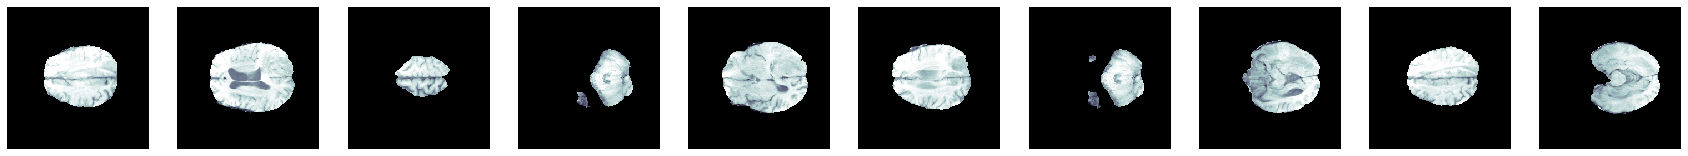

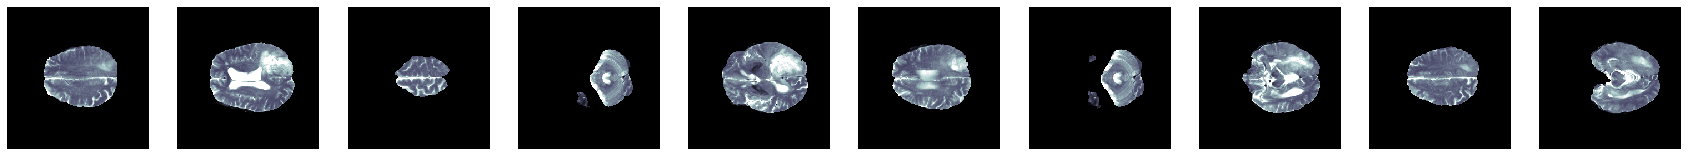

In [10]:
modalities = ['MR_T1_mri', 'MR_T2_mri']

for raw_record in validation.take(1):
    inp, ground_truth = take_images_from_raw(raw_record)

    print(inp.shape, ground_truth.shape)

    plt.figure(1 , figsize = (30, 20))
    print("Batch with a size of {} and dimension of (256,256) per image".format(BATCH_SIZE))
    n = 0 
    for i in range(10):     # batch size is different from 10, but let's show just 10 images 
    # to see all the images belonging to the batch, just change 10 with 'BATCH_SIZE'
        n += 1
        plt.subplot(2 , 10 , n)
        img = inp[i]
        plt.imshow(tf.squeeze(img), cmap='bone')
        plt.axis('off')

    n = 0 
    plt.figure(2 , figsize = (30, 20))
    for i in range(10):    
        n += 1
        plt.subplot(2 , 10 , n)
        img = ground_truth[i]
        plt.imshow(tf.squeeze(img), cmap='bone')
        plt.axis('off')

In [0]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 1

In [0]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [0]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [0]:
# hint from the web: Unfortunately, UNet does not work with arbitrary input sizes. Try ResNet instead.

def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,1], batch_size=BATCH_SIZE)

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]
  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same',
                                         kernel_initializer=initializer,activation='tanh') # (bs, 256, 256, 1)
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
generator = Generator()

In [0]:
def rescale(x, xmin, xmax, a, b):
    return (a + (b-a)*(x-xmin)/(xmax-xmin))  
    # to rescale in the range [0, 1], 'a' must be 0 and 'b' = 1

In [0]:
@tf.function
def normalize(image):
    image_normalized = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        # rescaling each image in the batch
        max_value = tf.math.reduce_max(image[i])
        min_value = tf.math.reduce_min(image[i])
        x = rescale(image[i], min_value, max_value, 0, 1)
        image_normalized = image_normalized.write(i, x)
    image_normalized = image_normalized.stack()
    return image_normalized

**Defining all the quantitative metrics (PSNR, SSIM, MSE and MS-SSIM(?))**

In [0]:
def compute_psnr(image1, image2):
    # Compute PSNR over tf.float32 Tensors.
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    psnr = tf.image.psnr(im1, im2, max_val=1.0)
    mean = tf.reduce_mean(tf.boolean_mask((psnr), tf.math.is_finite(psnr)))
    std = tf.math.reduce_std(tf.boolean_mask((psnr), tf.math.is_finite(psnr)))
    # In the computation of mean and std, I'm ignoring the 'nan' and 'inf' values
    # Why 'nan' values? 'nan' happens when there is an image with max_value and min_value = 0.0 so a black image
    # the PSNR would be inf (image is totally similar to the ground truth)
    # be rescaling the image, the max_value and min_value would become nan and so the PSNR

    # It ignores also the 'inf' values, in the case I don't want to normalize
    #print(psnr)
    return mean, std

In [0]:
# I want to compute, first thing, the MSE between ground truth and generated one. The tf.function gives me a Tensor 32x256x256:
# MSE is computed PIXEL per PIXEL, so per each of the 32 matrix 256x256, I average (1) the values of the 256x256 pixels obtaining
# an array of 32 elements, containing the MSEs of each image belonging to the batch. Then I can average (2) these 32 to have 
# I should not average the whole 32x256x256 in one step. The result would have same mean but slightly different std.
# I want first to obtain the MSE of each image... then I average across the batch only to have smth more accurate.

def compute_mse(image1, image2):       # mean squared error
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    mse = tf.metrics.mean_squared_error(im1,im2)
    # In this way is possible to do Variable item-assignment with tensors 
    mse_per_image = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        x = tf.reduce_mean(tf.boolean_mask((mse[i]), tf.math.is_finite(mse[i]))) 
        mse_per_image = mse_per_image.write(i, x)
    mse_per_image = mse_per_image.stack()
    mean = tf.reduce_mean(tf.boolean_mask((mse_per_image), tf.math.is_finite(mse_per_image)))
    std = tf.math.reduce_std(tf.boolean_mask((mse_per_image), tf.math.is_finite(mse_per_image)))
    return mean, std

In [0]:
def compute_ssim(image1, image2):
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    ssim = tf.image.ssim(im1, im2, max_val=1)
    mean = tf.reduce_mean(tf.boolean_mask((ssim), tf.math.is_finite(ssim)))
    std = tf.math.reduce_std(tf.boolean_mask((ssim), tf.math.is_finite(ssim)))
    #print(ssim)
    return mean, std

In [21]:
for raw_record in validation.take(1):
    inp, ground_truth = take_images_from_raw(raw_record)
    prediction = generator(inp, training=False)

    # MSE, PSNR, SSIM
    mean, std = compute_mse(ground_truth, prediction)
    print("MSE: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std = compute_psnr(ground_truth, prediction)
    print("PSNR: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std = compute_ssim(ground_truth, prediction)
    print("SSIM: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))


MSE: 0.0482 ± 0.0253
PSNR: 13.8435 ± 2.5371
SSIM: 0.8247 ± 0.0786


In [0]:
def generate_images(model, test_input, tar, train):
    
    # FROM STACKOVERFLOW:
    # Some neural network layers behave differently during training and inference, for example Dropout and BatchNorm
    # During training, dropout will randomly drop out units and correspondingly scale up activations of the remaining units.
    # During inference (training=false) it does nothing (since you usually don't want the randomness of dropping out units here).
    # The training argument lets the layer know which of the two "paths" it should take. 
    # If you set this incorrectly, your network might not behave as expected.
    
    prediction = model(test_input, training=train)
    
    print("1st sample from the batch. Dimension of (256,256) per image".format(BATCH_SIZE))
    
    display_list = [test_input, tar, prediction]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    plt.figure(1 , figsize = (12 , 12))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(tf.squeeze(display_list[i][0]), cmap='bone') # [0] = I'm showing only the 1st sample
        plt.axis('off')
    plt.show()
    return prediction


In [0]:
def generate_complete_batch(model, test_input, tar, train):
    prediction = model(test_input, training=train)

    print(prediction.shape)
    print("Batch with a size of {} and dimension of (256,256) per image".format(BATCH_SIZE))
    display_list = [test_input, tar, prediction]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.figure(i+1 , figsize = (30 , 30))
        n = 0
        for j in range(BATCH_SIZE):  # batch size is different from 10, but let's show just 10 images.
            n += 1
            plt.subplot(1, BATCH_SIZE, n).title.set_text(title[i])
            plt.imshow(tf.squeeze(display_list[i][j]), cmap='bone')
            plt.axis('off')


**Prediction of T2, given random input T1 and ground truth T2**


In [0]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)



  return total_gen_loss, gan_loss, l1_loss

In [0]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image', batch_size=BATCH_SIZE)
  tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image', batch_size=BATCH_SIZE)

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1) #(bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [0]:
discriminator = Discriminator()

In [0]:
def normalize_discriminator(image):
    image_normalized = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        # rescaling each image in the batch
        max_value = tf.math.reduce_max(image[i])
        min_value = tf.math.reduce_min(image[i])
        if tf.math.equal(max_value, 0) and tf.math.equal(max_value, 0):
            print("Found nan")
            x = rescale(image[i], 0, 0, 0, 1)
        else:
            x = rescale(image[i], min_value, max_value, 0, 1)
        print(i , min_value.numpy(), max_value.numpy())
        image_normalized = image_normalized.write(i, x)
    image_normalized = image_normalized.stack()
    return image_normalized

In [0]:
def resize_with_crop(image_input, image_ground_truth, image_prediction):
    # FROM THE PAPER: 
    # "In order to crop out the brain region from each sequence, we calculate the largest bounding box that 
    # can accommodate each brain in the whole dataset, and then use the coordinates to crop each sequence in every patient scan. 
    # The final cropped size of a single patient scan with all sequences contains 148 axial slices of size 194 × 155."

    # I use this size in order to have similar results to the ones reached by the paper.

    image_input = tf.image.resize_with_crop_or_pad(image_input, 155, 194)
    image_ground_truth = tf.image.resize_with_crop_or_pad(image_ground_truth, 155, 194)
    image_prediction = tf.image.resize_with_crop_or_pad(image_prediction, 155, 194)

    return image_input, image_ground_truth, image_prediction

1st sample from the batch. Dimension of (256,256) per image


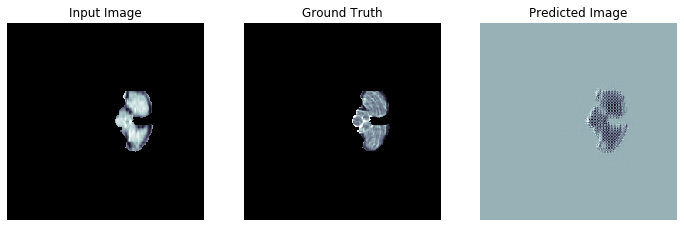

(32, 256, 256, 1) (32, 155, 194, 1)
PSNR: 5.1357 ± 0.5945
SSIM: 0.0043 ± 0.0054
MSE: 0.3095 ± 0.0446


In [30]:
modalities = ['MR_T1_mri', 'MR_T2_mri']
for raw_record in testing.take(1):
    inp, ground_truth = take_images_from_raw(raw_record)
# Shape of both input and target is: (bs, 256, 256, 1)

# GENERATE A NEW MODALITY:
# the functions below do exactly the same thing, but the first prints only the first sample from the batch, 
# while w/the second ALL the images of the batch are printed out.

    prediction = generate_images(generator, inp, ground_truth, False)
    inp_cr, ground_truth_cr, prediction_cr = resize_with_crop(inp, ground_truth, prediction)
    print(prediction.shape, prediction_cr.shape)

    # I'll use scans cropped to 155x194 in order to evaluate the GAN performances.

    # let's normalize the prediction, but not sure if it's the right thing to do. ask to the professor.
    # at the beginning, values of prediction are [-0.0307 0.0137], THEN after only two epochs on the whole dataset,
    # tehe generated image will range in [0, 1]

    prediction_normalized_cr = normalize(prediction_cr)
    
    """
    for i in range (BATCH_SIZE):
        max_value_image2 = np.amax(prediction[i])
        min_value_image2 = np.amin(prediction[i])
        max_value_image1 = np.amax(prediction_cr[i])
        min_value_image1 = np.amin(prediction_cr[i])
        print(i, min_value_image2, max_value_image2)
    """

    mean, std = compute_psnr(ground_truth_cr, prediction_normalized_cr)
    print("PSNR: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std = compute_ssim(ground_truth_cr, prediction_normalized_cr)
    print("SSIM: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std = compute_mse(ground_truth_cr, prediction_normalized_cr)
    print("MSE: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))


In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

**TRAINING PHASE**

In [0]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        # G produces fake images of T2
        gen_output = generator(input_image, training=True)

        # showing to D a batch of real images of T2
        disc_real_output = discriminator([input_image, target], training=True)
        
        # showing to D a batch fake images of T2
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)


    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))

    #return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

In [0]:
def fit(train_ds, epochs, val_ds):
  for epoch in range(epochs):
    start = time.time()

    # this has nothing to do with the training. 
    # It's just to show qualitatively the progress of the GAN in generating a new image.
    for raw_record in val_ds.take(1):
        example_input, example_target = take_images_from_raw(raw_record)
        prediction = generate_images(generator, example_input, example_target, True)

        inp_cr, target_cr, prediction_cr = resize_with_crop(example_input, example_target, prediction)

        prediction_normalized_cr = normalize(prediction_cr)
        mean, std = compute_mse(target_cr, prediction_cr)
        print("MSE: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
        mean2, std2 = compute_psnr(target_cr, prediction_cr)
        print("PSNR: {} ± {}".format((f'{mean2:.4f}'), (f'{std2:.4f}')))
        mean3, std3 = compute_ssim(target_cr, prediction_cr)
        print("SSIM: {} ± {}".format((f'{mean3:.4f}'), (f'{std3:.4f}')))

        
        mean, std = compute_psnr(target_cr, prediction_normalized_cr)
        print("PSNR norm: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
        mean, std = compute_ssim(target_cr, prediction_normalized_cr)
        print("SSIM norm: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
        mean, std = compute_mse(target_cr, prediction_normalized_cr)
        print("MSE norm: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))


    print("Epoch: ", epoch)

    # evaluate the model performance, sometimes
   
    # Train
    n = 0
    #for raw_record in train_ds.take(32):
    #for idx, raw_record in train_ds.enumerate():

    for idx, raw_record in train_ds.enumerate():
        n += 1
        input_image, target = take_images_from_raw(raw_record)
        print('.', end='')
        if (n+1) % 100 == 0:
            print()
            print(n+1)
        # THIS IS THE ACTUAL TRAINING STEP
        train_step(input_image, target, epoch)
        
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

1st sample from the batch. Dimension of (256,256) per image


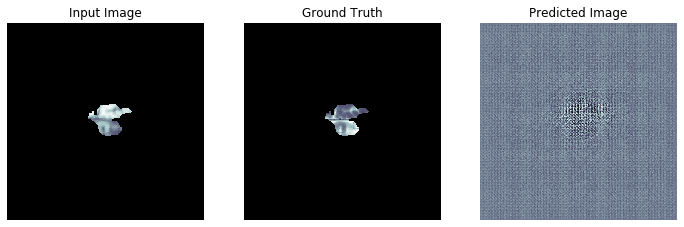

MSE: 0.1853 ± 0.0912
PSNR: 8.3038 ± 3.7047
SSIM: 0.0137 ± 0.0121
PSNR norm: 6.5439 ± 0.5110
SSIM norm: 0.0044 ± 0.0028
MSE norm: 0.2232 ± 0.0268
Epoch:  0
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
....................................................................................................
700
....................................................................................................
800
......

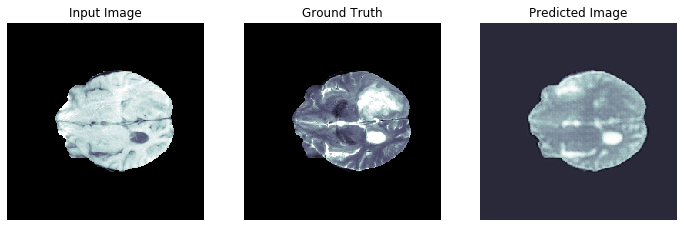

MSE: 0.0111 ± 0.0062
PSNR: 23.1762 ± 11.6464
SSIM: 0.7834 ± 0.1165
PSNR norm: 13.5384 ± 2.2612
SSIM norm: 0.1766 ± 0.0950
MSE norm: 0.0531 ± 0.0462
Epoch:  1
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
....................................................................................................
700
....................................................................................................
800
...

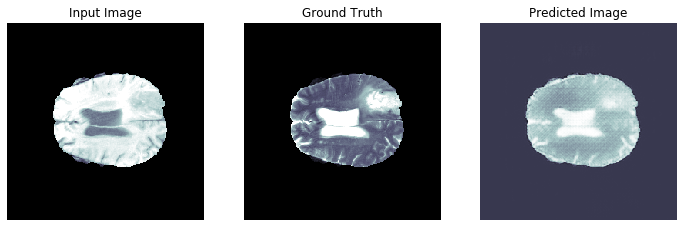

MSE: 0.0106 ± 0.0051
PSNR: 23.1434 ± 12.6099
SSIM: 0.7799 ± 0.1013
PSNR norm: 14.3427 ± 1.8684
SSIM norm: 0.1976 ± 0.0894
MSE norm: 0.0414 ± 0.0267
Epoch:  2
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
....................................................................................................
700
....................................................................................................
800
...

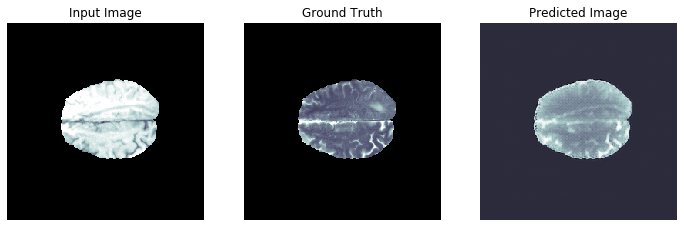

MSE: 0.0117 ± 0.0052
PSNR: 21.0194 ± 8.1623
SSIM: 0.8130 ± 0.0907
PSNR norm: 13.3269 ± 1.4580
SSIM norm: 0.1820 ± 0.0876
MSE norm: 0.0499 ± 0.0248
Epoch:  3
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
....................................................................................................
700
....................................................................................................
800
....

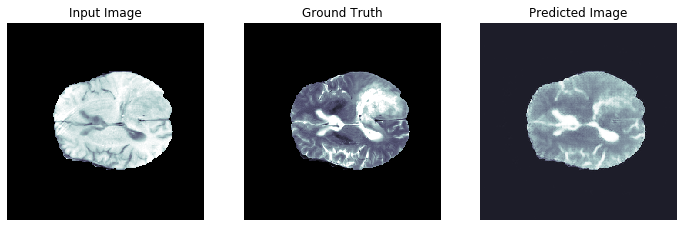

MSE: 0.0115 ± 0.0049
PSNR: 21.3799 ± 9.2237
SSIM: 0.7950 ± 0.0793
PSNR norm: 15.1763 ± 1.5985
SSIM norm: 0.2302 ± 0.0839
MSE norm: 0.0325 ± 0.0122
Epoch:  4
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
....................................................................................................
700
....................................................................................................
800
....

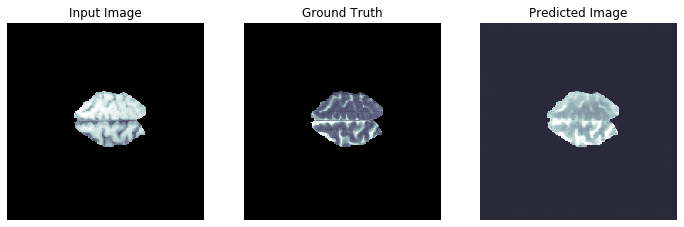

MSE: 0.0095 ± 0.0050
PSNR: 22.2267 ± 8.6683
SSIM: 0.8176 ± 0.0902
PSNR norm: 15.7842 ± 2.6396
SSIM norm: 0.2227 ± 0.1012
MSE norm: 0.0304 ± 0.0132
Epoch:  5
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
....................................................................................................
700
....................................................................................................
800
....

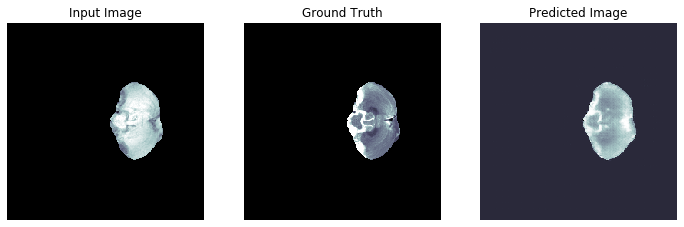

MSE: 0.0095 ± 0.0053
PSNR: 22.3563 ± 8.3379
SSIM: 0.8243 ± 0.0844
PSNR norm: 16.0920 ± 3.0963
SSIM norm: 0.2241 ± 0.1002
MSE norm: 0.0301 ± 0.0166
Epoch:  6
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
....................................................................................................
700
....................................................................................................
800
....

In [35]:
EPOCHS = 7

# training, validation, testing = load_datasets() # I'll use this in case I get stuck with the cache.
# Initialize the models, so that I don't have to restart the runtime again.
generator = Generator()
discriminator = Discriminator()
fit(training, EPOCHS, validation)

# in case it slows down too much, there is the option: 'reset all runtimes'

In [0]:
# in the testing there are 28 patients so 128*28 = 3584 samples
# each samples has then all the scans defined in the load_dataset (up to 4 scans + the segmented area)
# if batch size is set to 32, then there are less then 100 samples.

# training: with GPU it crashes, with TPU works. a bit more of 28000 samples -> 219 patients * 128 levels.

# training with 100 samples, batch size = 1 and TPU took 46 seconds
# training with 100 samples, batch size = 1 and GPU took 7/8 seconds

# training with 1000 samples, batch size = 1, resizing to 256, GPU took 54 seconds
# training with 1000 samples, batch size = 1, padding to 256, GPU took 52 seconds

# TRAINING TIMES WITH DIFFERENT BATCH SIZES:
# training with 16 samples and batch size = 64 (so 1024 samples fed to the GAN), TPU took 209 seconds

# training with 1000 samples and batch size = 1 (so 1000 samples fed to the GAN), GPU took about 490 seconds (8 min)
# training with 250 samples and bs = 4 (so 1000 samples fed to the GAN), GPU took 127 seconds!
# training with 128 samples and bs = 8 (so 1024 samples fed to the GAN), GPU took 75 seconds!
# training with 64 samples and bs = 16 (so 1024 samples fed to the GAN), GPU took 41 seconds!
# training with 31 samples and bs = 32 (so still 992 samples fed to the GAN), GPU took 28/32/33
# training with 16 samples and bs = 64 (so 1024 samples fed to the GAN), GPU took 23/25/26 seconds!

# training with 8 samples and bs = 128, GPU took 24/25( 21 in the most recent) sec! -> not so good quality
# (It has been observed in practice that when using a larger batch there is a significant degradation in the 
# quality of the model, as measured by its ability to generalize.)
# https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network

# The resulting model may not generalize as well as a model trained with a small batch size

# tradeoff between 32 and 64. 32 seems to be qualitatively more accurate but it's a bit slower. 
# before choosing, it would be better to implement also the quantitative metrics.

# from pix2pix paper: use batch sizes between 1 and 10 depending on the experiment


# In general, batch size of 32 is a good starting point, and you should also try with 64, 128, and 256. 
# Other values (lower or higher) may be fine for some data sets, but the given range is generally the best to 
# start experimenting with. Though, under 32, it might get too slow because of significantly lower computational speed, 
# because of not exploiting vectorization to the full extent.  
# If you get an "out of memory" error, you should try reducing the mini-batch size anyway.


# training with 4 samples and bs = 256, GPU run out of memory. Resource exhausted.

In [0]:
# np.FUNCTION VS tf.FUNCTION

# np =  training with 31 samples and bs = 32 (992 samples fed to the GAN), GPU took 28/32/33
# training with 32 samples and bs = 32 (1024 samples fed to the GAN), GPU took 14/15/16/17 seconds 

In [0]:
tf.keras.backend.clear_session()  # For easy reset of notebook state.

**Evaluating the final model with the test set**

In [39]:
"""
modalities = ['MR_T1_mri', 'MR_T2_mri']
for raw_record in training.take(1):
    inp, ground_truth = take_images_from_raw(raw_record)
# Shape of both input and target is: (bs, 256, 256, 1)

    prediction = generate_images(generator, inp, ground_truth, False)
    #generate_complete_batch(generator, example_input, example_target, False)

    prediction_normalized = normalize(prediction)
    
    
    for i in range (BATCH_SIZE):
        max_value_image2 = np.amax(prediction[i])
        min_value_image2 = np.amin(prediction[i])
        max_value_image1 = np.amax(prediction_normalized[i])
        min_value_image1 = np.amin(prediction_normalized[i])
        print(i, min_value_image2, max_value_image2, min_value_image1, max_value_image1)
        

    mean, std = compute_psnr(ground_truth, prediction_normalized)
    print("PSNR: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std = compute_psnr(ground_truth, prediction)
    print("PSNR: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    """

'\nmodalities = [\'MR_T1_mri\', \'MR_T2_mri\']\nfor raw_record in training.take(1):\n    inp, ground_truth = take_images_from_raw(raw_record)\n# Shape of both input and target is: (bs, 256, 256, 1)\n\n    prediction = generate_images(generator, inp, ground_truth, False)\n    #generate_complete_batch(generator, example_input, example_target, False)\n\n    prediction_normalized = normalize(prediction)\n    \n    \n    for i in range (BATCH_SIZE):\n        max_value_image2 = np.amax(prediction[i])\n        min_value_image2 = np.amin(prediction[i])\n        max_value_image1 = np.amax(prediction_normalized[i])\n        min_value_image1 = np.amin(prediction_normalized[i])\n        print(i, min_value_image2, max_value_image2, min_value_image1, max_value_image1)\n        \n\n    mean, std = compute_psnr(ground_truth, prediction_normalized)\n    print("PSNR: {} ± {}".format((f\'{mean:.4f}\'), (f\'{std:.4f}\')))\n    mean, std = compute_psnr(ground_truth, prediction)\n    print("PSNR: {} ± {}".f

1st sample from the batch. Dimension of (256,256) per image


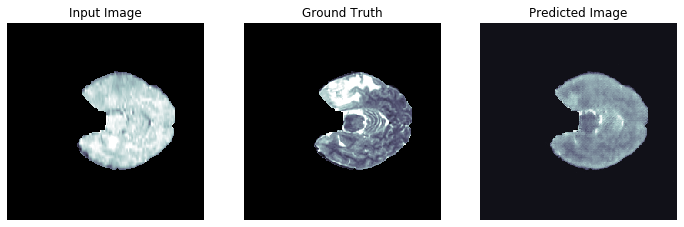

0 -0.08593538 0.99033165 0.0 1.0
1 -0.20269753 0.99365085 0.0 1.0
2 -0.041654285 0.8922821 0.0 1.0
3 -0.19546615 0.9105871 0.0 1.0
4 -0.087466545 0.85059685 0.0 1.0
5 -0.17921776 0.99999064 0.0 1.0
6 -0.039682243 0.99999464 0.0 1.0
7 -0.11350078 0.95050025 0.0 1.0
8 -0.14540389 0.9999564 0.0 1.0
9 -0.05810071 0.9668027 0.0 1.0
10 -0.03512792 0.9999971 0.0 1.0
11 -0.1496028 0.9982726 0.0 1.0
12 -0.057477396 0.94568264 0.0 1.0
13 -0.07865639 0.9187714 0.0 1.0
14 -0.1454723 0.89050865 0.0 1.0
15 -0.12042602 0.999917 0.0 1.0
16 -0.20994207 0.9969695 0.0 1.0
17 -0.1530947 0.98575294 0.0 1.0
18 -0.088809595 0.9190747 0.0 1.0
19 -0.0736729 0.99946564 0.0 1.0
20 -0.1609469 0.9949465 0.0 1.0
21 -0.14822124 0.9911007 0.0 1.0
22 -0.22078699 0.9998152 0.0 1.0
23 -0.07472753 0.99995404 0.0 1.0
24 -0.14779408 0.9999116 0.0 1.0
25 -0.13992919 0.9984207 0.0 1.0
26 -0.046990555 0.9999695 0.0 1.0
27 -0.15443537 0.99252456 0.0 1.0
28 -0.06482143 0.9999728 0.0 1.0
29 -0.13321976 0.99991864 0.0 1.0
30 -0.1

In [40]:
modalities = ['MR_T1_mri', 'MR_T2_mri']
for raw_record in testing.take(1):
    inp, ground_truth = take_images_from_raw(raw_record)
# Shape of both input and target is: (bs, 256, 256, 1)

    prediction = generate_images(generator, inp, ground_truth, False)
    #generate_complete_batch(generator, example_input, example_target, False)

    prediction_normalized = normalize(prediction)
    
    for i in range (BATCH_SIZE):
        max_value_image2 = np.amax(prediction[i])
        min_value_image2 = np.amin(prediction[i])
        max_value_image1 = np.amax(prediction_normalized[i])
        min_value_image1 = np.amin(prediction_normalized[i])
        print(i, min_value_image2, max_value_image2, min_value_image1, max_value_image1)
        

    mean, std = compute_psnr(ground_truth, prediction_normalized)
    print("PSNR: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std = compute_psnr(ground_truth, prediction)
    print("PSNR: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))

In [41]:
for raw_record in testing.take(1):
        generator.evaluate_model()
        example_input, example_target = take_images_from_raw(raw_record)
        prediction = generate_images(generator, example_input, example_target, True)
        prediction_normalized = normalize(prediction)

        mean, std = compute_mse(example_target, prediction_normalized)
        print("MSE: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
        mean2, std2 = compute_psnr(example_target, prediction_normalized)
        print("PSNR: {} ± {}".format((f'{mean2:.4f}'), (f'{std2:.4f}')))
        mean3, std3 = compute_ssim(example_target, prediction_normalized)
        print("SSIM: {} ± {}".format((f'{mean3:.4f}'), (f'{std3:.4f}')))


        a = generator.evaluate(example_input, example_target, batch_size=32, verbose=1)
        print(a)


AttributeError: ignored

In [0]:
modalities = ['MR_T1_mri', 'MR_T2_mri']
for raw_record in testing.take(10):
    inp, ground_truth = take_images_from_raw(raw_record)
# Shape of both input and target is: (bs, 256, 256, 1)

# GENERATE A NEW MODALITY:
# the functions below do exactly the same thing, but the first prints only the first sample from the batch, 
# while w/the second ALL the images of the batch are printed out.

    prediction, prediction_normalized = generate_images2(generator, inp, ground_truth, False)

    #prediction_normalized = normalize(prediction)
    
    for i in range (BATCH_SIZE):
        max_value_image2 = np.amax(prediction[i])
        min_value_image2 = np.amin(prediction[i])
        max_value_image1 = np.amax(prediction_normalized[i])
        min_value_image1 = np.amin(prediction_normalized[i])
        print(i, min_value_image2, max_value_image2, min_value_image1, max_value_image1)


    
    mean, std = compute_psnr(ground_truth, prediction)
    print("PSNR prediction: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    
    mean, std = compute_psnr(ground_truth, prediction_normalized)
    print("PSNR prediction normalized: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    


    prediction_normalized = normalize_discriminator(prediction)

    # vedere cosa succede al discriminator quando gli entrano dei 'nan' values.
    disc_out = discriminator([inp, prediction], training=False)
    disc_out2 = discriminator([inp, prediction_normalized], training=False)

    disc_real_output = discriminator([inp, ground_truth], training=True)
    
    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_out, prediction, ground_truth)
    disc_loss = discriminator_loss(disc_real_output, disc_out)
    gen_total_loss2, gen_gan_loss2, gen_l1_loss2 = generator_loss(disc_out2, prediction_normalized, ground_truth)
    disc_loss2 = discriminator_loss(disc_real_output, disc_out2)
    
    print(gen_total_loss.numpy(), gen_gan_loss.numpy(), gen_l1_loss.numpy(), disc_loss.numpy())
    print(gen_total_loss2.numpy(), gen_gan_loss2.numpy(), gen_l1_loss2.numpy(), disc_loss2.numpy()) # if a 'nan' image is found,
    # all the values of the losses will be 'nan'
    